In [2]:
import sys, scipy
sys.path.append('./../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from systematics_module.corr import *

CMB LENSING 

In [8]:
def loadfits_twopoint(fitsname, covmat_name="COVMAT"):
    
    import twopoint
    f = twopoint.TwoPointFile.from_fits(fitsname, covmat_name=covmat_name)
    
    xip = f.get_spectrum('xip').value
    xim = f.get_spectrum('xim').value
    gammat = f.get_spectrum('gammat').value
    wtheta = f.get_spectrum('wtheta').value
    galaxy_cmbkappa_xi = f.get_spectrum('galaxy_cmbkappa_xi').value
    shear_cmbkappa_xi = f.get_spectrum('shear_cmbkappa_xi').value

    angle = f.get_spectrum('galaxy_cmbkappa_xi').angle
    
    if covmat_name is None : 
        return [angle, galaxy_cmbkappa_xi]
    else : 
        covmat = f.covmat
        starts = f.covmat_info.starts
        covmat_galaxy_cmbkappa_xi = covmat[starts[4]:starts[5], starts[4]:starts[5]]
        return [angle, galaxy_cmbkappa_xi, covmat_galaxy_cmbkappa_xi]        

In [25]:
def brelchisqr(xi, xi2, invcov, brel):
    DiffVector = brel*xi - xi2
    chi2 = np.dot( np.dot( DiffVector , invcov), DiffVector )
    return chi2


def find_nearest(array, value, brell):
    
    ind_min = array.argmin()
    array1 = np.asarray(array[:ind_min])
    idx1 = (np.abs(array1 - value)).argmin()
    
    array2 = np.asarray(array[ind_min:])
    idx2 = (np.abs(array2 - value)).argmin()
    
    return brell[:ind_min][idx1], brell[ind_min], brell[ind_min:][idx2]


def brel_chisqr_fitting(xi1, xi2, Fisher, verbose=False):
    
    brelarr = np.linspace(0.3, 1.5, 5000)  
    chisqr_result = np.zeros(brelarr.size)
    
    i=0
    for b in brelarr:
        chisqr_result[i] = brelchisqr(xi1, xi2, Fisher, b)
        i+=1   
        
    minarg = chisqr_result.argmin()
    chisqr_min = chisqr_result.min()
    brel = brelarr[minarg]
    
    b_cmass = 2.0
    db = b_cmass * (1. - 1./brel)

    br1, brmin, br2 = find_nearest( chisqr_result, chisqr_min + 1, brelarr )
    err_brel = np.abs(br1-br2)/2.
    err_db = err_brel *b_cmass
    
    
    if verbose : print 'err db, db / br1, brmin, br2 :', err_db, db, br1, brmin, br2  
    #return err_db, db, chisqr_result

    return err_brel, brel, chisqr_result
    
    

In [27]:
fitsname = '/n/des/lee.5922/programs/cosmolike/cosmosis/output_cmblensing_cmass/cmblensing_cmass_sgc_lrange8_2048_fwhm1p71.fits'
angle, xi_gk_sgc, cov_gk_sgc_analytic = loadfits_twopoint(fitsname)
err_gk_sgc = np.sqrt(cov_gk_sgc_analytic.diagonal())

fitsname = '/n/des/lee.5922/programs/cosmolike/cosmosis/output_cmblensing_cmass/cmblensing_cmass_ngc_lrange8_2048_fwhm1p71.fits'
angle, xi_gk_ngc, cov_gk_ngc_analytic = loadfits_twopoint(fitsname)
err_gk_ngc = np.sqrt(cov_gk_ngc_analytic.diagonal())

F_gk_sgc = np.linalg.pinv(cov_gk_sgc_analytic, rcond=1e-5)
F_gk_ngc = np.linalg.pinv(cov_gk_ngc_analytic, rcond=1e-5)
cov_gk_full_analytic = np.linalg.pinv( F_gk_sgc + F_gk_ngc , rcond=1e-5 )
err_gk_full = np.sqrt(cov_gk_full_analytic.diagonal())

fitsname = '/n/des/lee.5922/programs/cosmolike/cosmosis/output_cmblensing_cmass/cmblensing_dmass_lrange8_2048_fwhm1p71.fits'
angle, xi_gk_dmass, cov_gk_dmass_analytic = loadfits_twopoint(fitsname)
err_gk_dmass = np.sqrt(cov_gk_dmass_analytic.diagonal())

In [58]:
cmblensing_dir = '../output/cmblensing/'
HFactor158 = 1.0

#rmin_cmb_dmass, kappa_cmb_dmass = np.genfromtxt(cmblensing_dir + 'w_dmass_x_cmblensing_systot.txt', unpack=True)
#cov_cmb_dmass = np.genfromtxt(cmblensing_dir + 'w_dmass_x_cmblensing_systot.cov') * 1./HFactor158
#err_cmb_dmass = np.sqrt( cov_cmb_dmass.diagonal() )

rmin_cmb_sgc, kappa_cmb_sgc = np.genfromtxt(cmblensing_dir + 'w_cmass_south_x_cmblensing.txt', unpack=True)
#cov_cmb_sgc = np.genfromtxt(cmblensing_dir + 'w_cmass_south_x_cmblensing.cov')* 1./HFactor158
#err_cmb_sgc = np.sqrt( cov_cmb_sgc.diagonal() )

rmin_cmb_ngc, kappa_cmb_ngc = np.genfromtxt(cmblensing_dir + 'w_cmass_north_x_cmblensing.txt', unpack=True)
#cov_cmb_ngc = np.genfromtxt(cmblensing_dir + 'w_cmass_north_x_cmblensing.cov')* 1./HFactor158
#err_cmb_ngc = np.sqrt( cov_cmb_ngc.diagonal() )

rmin_cmb_full, kappa_cmb_full, err_cmb_full = np.genfromtxt(cmblensing_dir + 'w_cmass_tot_x_cmblensing.txt', unpack=True)
#cov_cmb_full = np.linalg.inv(np.linalg.inv(cov_cmb_sgc)+np.linalg.inv(cov_cmb_ngc))* 1./HFactor158
#err_cmb_full = err_cmb_full * 1./np.sqrt(HFactor158)

rmin_cmb_dmass, kappa_cmb_dmass = np.genfromtxt(cmblensing_dir + 're/out_DMASS_nosysweight_mean.out', unpack=True)
#cov_cmb_dmass = np.genfromtxt(cmblensing_dir + 're/out_DMASS_nosysweight.cov') * 1./HFactor158
#err_cmb_dmass = np.sqrt( cov_cmb_dmass.diagonal() )

rmin_cmb_dmass_sys, kappa_cmb_dmass_sys = np.genfromtxt(cmblensing_dir + 're/out_DMASS_withsysweight_mean.out', unpack=True)
#cov_cmb_dmass_sys = np.genfromtxt(cmblensing_dir + 're/out_DMASS_withsysweight.cov') * 1./HFactor158
#err_cmb_dmass_sys = np.sqrt( cov_cmb_dmass_sys.diagonal() )

# theory ============
#rmin_cmb_th, kappa_cmb_theory = np.genfromtxt(cmblensing_dir+'theory_cmass_tot_cmblensing_b2.txt', unpack=True)
rmin_cmb_th, kappa_cmb_theory = np.genfromtxt(cmblensing_dir+'re/cmassnorth_cmbkappa_galbias1p75.asc', unpack=True)
kappa_cmb_theory_interp = scipy.interpolate.interp1d(rmin_cmb_th, kappa_cmb_theory)
kappa_cmb_theory_interp = kappa_cmb_theory_interp(rmin_cmb_dmass)


In [155]:
"""
amidir = '/n/des/lee.5922/data/dmass_cat/ami_result/'
meanr, xi = np.loadtxt(amidir+'out_DMASS_mean.out', unpack=True)
meanr, xis = np.loadtxt(amidir+'out_CMASS_South_mean.out', unpack=True)
meanr, xin = np.loadtxt(amidir+'out_CMASS_North_mean.out', unpack=True)

#xi = xi[2:]
#xis = xis[2:]
#xin = xin[2:]
#meanr = meanr[2:]


meanr_th, xi_theory = np.loadtxt('/n/des/lee.5922/data/cmass_cat/cmassnorth_cmbkappa_galbias1p75.asc', unpack=True)
xi_theory = scipy.interpolate.interp1d(meanr_th, xi_theory, kind='cubic')
xi_theory = xi_theory(meanr)
"""


In [157]:
#nzs_ratio = np.sqrt(0.9526592040362819)

In [221]:
"""
cov_cmass_n = np.genfromtxt(amidir+'out_CMASS_North.cov')#[2:,2:]
cov_cmass_s = np.genfromtxt(amidir+'out_CMASS_South.cov')#[2:,2:]
cov_dmass = np.genfromtxt(amidir+'out_DMASS.cov')#[2:,2:]

HF = lambda Nr,Nbin: 1#(Nr-Nbin-2) *1./(Nr-1)
HFn = 1. #HF(100, 20)
HFs = 1. #HF(100, 20)
HFd = 1. #HF(100, 20)

print HFn

#F_ns = HFn * HFs * np.linalg.inv(cov_cmass_n) + np.linalg.inv(cov_cmass_s)
#F_nd = HFn * HFd * np.linalg.inv(cov_cmass_n) + np.linalg.inv(cov_dmass)
#F_sd = HFs * HFd * np.linalg.inv(cov_cmass_s) + np.linalg.inv(cov_dmass)

F_ns = HFn * HFs * np.linalg.inv(cov_cmass_n + cov_cmass_s)
F_nd = HFn * HFd * np.linalg.inv(cov_cmass_n + cov_dmass)
F_sd = HFs * HFd * np.linalg.inv(cov_cmass_s + cov_dmass)

#cov_cmass = np.linalg.inv(F_cmass)
"""

1.0


In [74]:
F_fd = np.linalg.pinv(cov_gk_full_analytic + cov_gk_dmass_analytic, rcond=1e-5)
F_ns = np.linalg.pinv(cov_gk_ngc_analytic + cov_gk_sgc_analytic, rcond=1e-5)
F_nd = np.linalg.pinv(cov_gk_ngc_analytic + cov_gk_dmass_analytic, rcond=1e-5)
F_sd = np.linalg.pinv(cov_gk_sgc_analytic + cov_gk_dmass_analytic, rcond=1e-5)

In [75]:
mock_full = np.random.multivariate_normal( kappa_cmb_theory_interp, cov_gk_full_analytic, size=1000 )
mock_n = np.random.multivariate_normal( kappa_cmb_theory_interp, cov_gk_ngc_analytic, size=1000 )
mock_s = np.random.multivariate_normal( kappa_cmb_theory_interp, cov_gk_sgc_analytic, size=1000 )
mock_d = np.random.multivariate_normal( kappa_cmb_theory_interp, cov_gk_dmass_analytic, size=1000 )

<Container object of 3 artists>

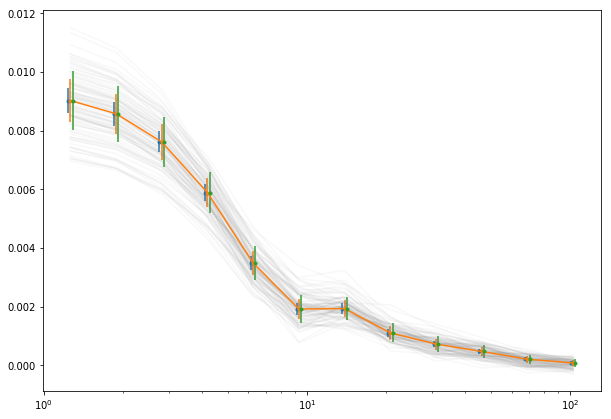

In [76]:
fig, ax = plt.subplots(figsize=(10,7))
for i in range(100): 
    ax.semilogx(rmin_cmb_dmass, mock_d[i], color='grey', alpha = 0.05)
ax.errorbar(rmin_cmb_dmass*0.98, kappa_cmb_theory_interp, yerr=np.sqrt(cov_gk_ngc_analytic.diagonal()), fmt='.')
ax.errorbar(rmin_cmb_dmass, kappa_cmb_theory_interp, yerr=np.sqrt(cov_gk_sgc_analytic.diagonal()), fmt='.-')
ax.errorbar(rmin_cmb_dmass*1.02, kappa_cmb_theory_interp, yerr=np.sqrt(cov_gk_dmass_analytic.diagonal()), fmt='.')

In [77]:
brel_ns = np.zeros(1000)
chisqr_array_ns = np.zeros((1000, 5000))
brel_sd = np.zeros(1000)
chisqr_array_sd = np.zeros((1000, 5000))

brel_nd = np.zeros(1000)
chisqr_array_nd = np.zeros((1000, 5000))

brel_fd = np.zeros(1000)
chisqr_array_fd = np.zeros((1000, 5000))

for i in range(1000):
    _, brel_ns[i], chisqr_array_ns[i] = brel_chisqr_fitting(mock_s[i], mock_n[i], F_ns)
    _, brel_nd[i], chisqr_array_nd[i] = brel_chisqr_fitting(mock_d[i], mock_n[i], F_nd)
    _, brel_sd[i], chisqr_array_sd[i] = brel_chisqr_fitting(mock_d[i], mock_s[i], F_sd)
    _, brel_fd[i], chisqr_array_fd[i] = brel_chisqr_fitting(mock_d[i], mock_full[i], F_fd)
    print i, '\r',
    
bshift_ns= 1./np.mean(brel_ns)
bshift_nd= 1./np.mean(brel_nd)
bshift_sd= 1./np.mean(brel_sd)
bshift_fd= 1./np.mean(brel_fd)

print bshift_ns, bshift_nd, bshift_sd, bshift_fd

1.0386070971997459 1.0784764999560756 1.0791903348067662 1.079107867268394


In [72]:
bshift_ns= 1./np.mean(brel_ns)
bshift_nd= 1./np.mean(brel_nd)
bshift_sd= 1./np.mean(brel_sd)
bshift_fd= 1./np.mean(brel_fd)
print bshift_ns, bshift_nd, bshift_sd, bshift_fd

1.7751500301835874 1.4970203336028511 0.8657626296738886 1.2466023291189747


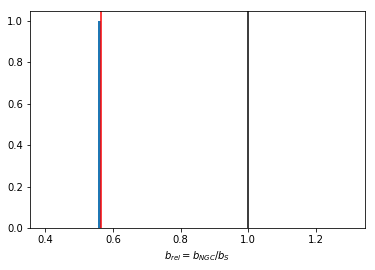

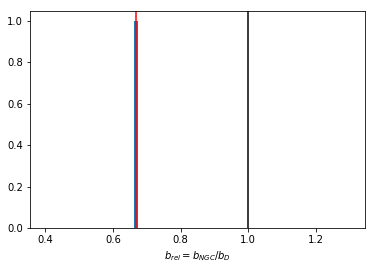

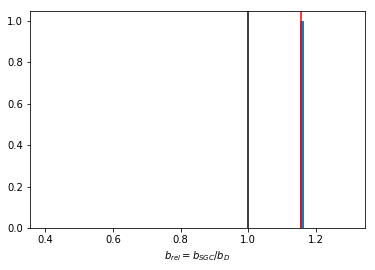

In [73]:
bins, bs = np.linspace(0.4, 1.3, 100, retstep=True)
bincent = bins[:-1] + bs/2.

fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_ns, bins = bins)

meanv = np.mean(brel_ns)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
#ax.set_xlim(0.95, 1.05)
ax.set_xlabel('$b_{rel} = b_{NGC} /b_S$')

fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_nd, bins = bins)

meanv = np.mean(brel_nd)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
#ax.set_xlim(0.95, 1.05)
ax.set_xlabel('$b_{rel} = b_{NGC} /b_D$')


fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_sd, bins = bins)

meanv = np.mean(brel_sd)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
#ax.set_xlim(0.95, 1.05)
ax.set_xlabel('$b_{rel} = b_{SGC} /b_D$')

In [184]:
nzs_ratio

0.9760426240878427

In [68]:
err_brel_fd, brel_fd, chisqr_result_fd = brel_chisqr_fitting(kappa_cmb_dmass, kappa_cmb_full, F_fd, verbose=True)
err_brel_ns, brel_ns, chisqr_result_ns = brel_chisqr_fitting(kappa_cmb_sgc, kappa_cmb_ngc, F_ns, verbose=True)
err_brel_nd, brel_nd, chisqr_result_nd = brel_chisqr_fitting(kappa_cmb_dmass,  kappa_cmb_ngc, F_nd, verbose=True)
err_brel_sd, brel_sd, chisqr_result_sd = brel_chisqr_fitting(kappa_cmb_dmass,  kappa_cmb_sgc, F_sd, verbose=True)

err db, db / br1, brmin, br2 : 0.2030806161232246 -0.49320465823794946 0.7006401280256052 0.8021804360872173 0.9037207441488297
err db, db / br1, brmin, br2 : 0.12650530106021196 -1.5503000603671748 0.4999599919983997 0.5633326665333066 0.6264652930586116
err db, db / br1, brmin, br2 : 0.20764152830566107 -0.9940406672057023 0.5642928585717143 0.6679935987197438 0.7719343868773754
err db, db / br1, brmin, br2 : 0.23428685737147426 0.26847474065222277 1.0379075815163032 1.1550510102020404 1.2721944388877775


In [228]:
#err_db_nn, db_nn, chisqr_result_nn = brel_chisqr_fitting(xin, xi_theory, np.linalg.inv(cov_cmass_n))

#err_db_ns, db_ns, chisqr_result_ns = brel_chisqr_fitting(xis, xi_theory, F_ns)
#err_db_nd, db_nd, chisqr_result_nd = brel_chisqr_fitting(xi,  xi_theory, F_nd)
#err_db_sd, db_sd, chisqr_result_sd = brel_chisqr_fitting(xi,  xis, F_sd)

#err_brel_ns, brel_ns, chisqr_result_ns = brel_chisqr_fitting(xis, xin, F_ns, verbose=True)
#err_brel_nd, brel_nd, chisqr_result_nd = brel_chisqr_fitting(xi,  xin, F_nd, verbose=True)
#err_brel_sd, brel_sd, chisqr_result_sd = brel_chisqr_fitting(xi,  xis, F_sd, verbose=True)

#err_brel_ns, brel_ns, chisqr_result_ns = brel_chisqr_fitting(xi_theory, xis, np.linalg.inv(cov_cmass_s), verbose=True)
#err_brel_nd, brel_nd, chisqr_result_nd = brel_chisqr_fitting(xi_theory,  xi, np.linalg.inv(cov_dmass), verbose=True)
#err_brel_sd, brel_sd, chisqr_result_sd = brel_chisqr_fitting(xi_theory,  xin, np.linalg.inv(cov_cmass_n), verbose=True)

err db, db / br1, brmin, br2 : 0.2338067613522703 -0.2592818565972932 0.7683336667333467 0.8852370474094817 1.002140428085617
err db, db / br1, brmin, br2 : 0.23572714542908568 -0.5403358995858425 0.6694338867773555 0.7872974594918983 0.9051610322064412
err db, db / br1, brmin, br2 : 0.27677535507101414 -0.5165496237005716 0.6562312462492499 0.7947389477895579 0.933006601320264


In [69]:
print err_brel_fd, ',', brel_fd
print err_brel_ns, ',', brel_ns
print err_brel_nd, ',', brel_nd
print err_brel_sd, ',', brel_sd

0.1015403080616123 , 0.8021804360872173
0.06325265053010598 , 0.5633326665333066
0.10382076415283054 , 0.6679935987197438
0.11714342868573713 , 1.1550510102020404


50.699695161599
34.40142012330072
16.74602498057296
4.224974596799917
2.8667850102750596
1.3955020817144135


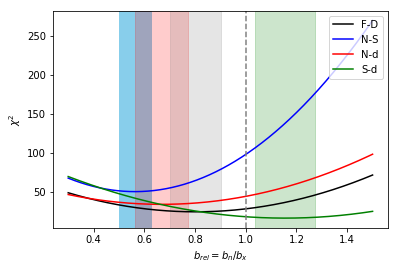

In [70]:
fig, ax = plt.subplots()

b_n = 2.0
brel = np.linspace(0.3, 1.5, 5000)    
dbarray = b_n*(1-brel)

#ax.plot(dbarray, chisqr_result_nn, '-k', label='N-N')
ax.plot(brel, chisqr_result_fd, '-k', label='F-D')
ax.plot(brel, chisqr_result_ns, '-b', label='N-S')
ax.plot(brel, chisqr_result_nd, '-r',label='N-d')
ax.plot(brel, chisqr_result_sd, '-g',label='S-d')

#ax.plot(brel, chisqr_result_nd_new, '-m',label='N-d2')
#ax.plot(dbarray, chisqr_result_ns_nzs_ratio, color='orange', ls='--',label='N-S nzs_ratio')

#ax.errorbar(db_ns, chisqr_min_ns, xerr =err_brel_ns *b_cmass)
#ax.errorbar(db_nd, chisqr_min_nd, xerr =err_brel_nd *b_cmass)
#ax.errorbar(db_sd, chisqr_min_sd, xerr =err_brel_sd *b_cmass)

#ax.axvline(db_ns, lw = err_brel_ns *b_cmass, alpha = 0.5)

#ax.axvspan(db_nn-err_db_nn, db_nn+err_db_nn, alpha=0.2, color='grey')
ax.axvspan(brel_ns-err_brel_ns, brel_ns+err_brel_ns, alpha=0.99, color='skyblue')
ax.axvspan(brel_nd-err_brel_nd, brel_nd+err_brel_nd, alpha=0.2, color='red')
ax.axvspan(brel_sd-err_brel_sd, brel_sd+err_brel_sd, alpha=0.2, color='green')
ax.axvspan(brel_fd-err_brel_fd, brel_fd+err_brel_fd, alpha=0.2, color='grey')
#ax.axvspan(db_ns_nzs_ratio-err_db_ns_nzs_ratio, db_ns_nzs_ratio+err_db_ns_nzs_ratio, alpha=0.2, color='orange')

ax.axvline(x=1.0, color = 'grey', ls='--')

ax.set_xlabel(r'$b_{rel} = b_n/b_x$')
ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.axhline(y = chisqr_min_ns+1)
#ax.axhline(y = chisqr_min_nd+1)
#ax.axhline(y = chisqr_min_sd+1)

print chisqr_result_ns.min()
print chisqr_result_nd.min()
print chisqr_result_sd.min()


print chisqr_result_ns.min()/12
print chisqr_result_nd.min()/12
print chisqr_result_sd.min()/12

#ax.set_xlim(0.88, 1.06)

0.11228294449770954 , 1.0
0.1554217949869733 , 1.0
0.10141840286797942 , 1.0


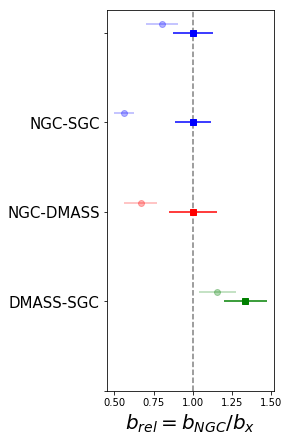

In [71]:
fig, ax = plt.subplots(figsize = (3,7))

brelsqr = np.linspace(0.8, 1.5, 50000) 
b_n = 2.0
brel = np.sqrt(brelsqr)
dbarray = b_n*(1-brel)

ax.errorbar(brel_fd, 4.1, xerr =err_brel_fd, fmt='-o', color='blue', alpha = 0.3)
ax.errorbar(brel_ns, 3.1, xerr =err_brel_ns, fmt='-o', color='blue', alpha = 0.3)
ax.errorbar(brel_nd, 2.1, xerr =err_brel_nd, fmt='-o', color = 'red', alpha = 0.3)
ax.errorbar(brel_sd, 1.1, xerr =err_brel_sd, fmt='-o', color = 'green', alpha = 0.3)

ax.errorbar(brel_fd*bshift_fd, 4, xerr =err_brel_fd*bshift_fd, fmt='-s', color='blue')
ax.errorbar(brel_ns*bshift_ns, 3, xerr =err_brel_ns*bshift_ns, fmt='-s', color='blue')
ax.errorbar(brel_nd*bshift_nd, 2, xerr =err_brel_nd*bshift_nd, fmt='-s', color = 'red')
ax.errorbar(brel_sd/bshift_sd, 1, xerr =err_brel_sd/bshift_sd, fmt='-s', color = 'green')

print err_brel_ns*bshift_ns, ',', brel_ns*bshift_ns
print err_brel_nd*bshift_nd, ',', brel_nd*bshift_nd
print err_brel_sd*bshift_sd, ',', brel_sd*bshift_sd

#ax.errorbar(brel_ns_nzs_ratio, 2, xerr = err_brel_ns_nzs_ratio, fmt='-o', color='orange')

#ax.axvline(db_ns, lw = err_brel_ns *b_cmass, alpha = 0.5)
#ax.axvspan(brel_ns-err_brel_ns, brel_ns+err_brel_ns, alpha=0.99, color='skyblue')

#ax.axvspan(brel_sd-err_brel_sd, brel_sd+err_brel_sd, alpha=0.2, color='green')
#ax.axvspan(brel_ns_nzs_ratio-err_brel_ns_nzs_ratio, brel_ns_nzs_ratio+err_db_ns_nzs_ratio, alpha=0.2, color='orange')
#ax.axvspan(brel_nd-err_brel_nd, brel_nd+err_brel_nd, alpha=0.2, color='red')
ax.axvline(x=1.0, color = 'grey', ls='--')
#ax.axvline(x=0, color = 'grey', ls='--')

ax.set_xlabel(r'$b_{rel} = b_{NGC}/b_{x}$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.set_xlim(0.94, 1.1)
#ax.axhline(y = chisqr_min_ns+1)
#ax.axhline(y = chisqr_min_nd+1)
#ax.axhline(y = chisqr_min_sd+1)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['','DMASS-SGC','NGC-DMASS', 'NGC-SGC' ,''], fontsize = 15) 
#print chi2.sf(chisqr_min_ns,9), chi2.sf(chisqr_min_nd,9), chi2.sf(chisqr_min_sd,9)
#print chi2.sf(chinull_ns,9), chi2.sf(chinull_nd,9), chi2.sf(chinull_sd,9)

0.1272173234990249 , 0.9633381616704914
0.13433505515671507 , 0.8973226011206445
0.16200564392255426 , 0.9303732621276611


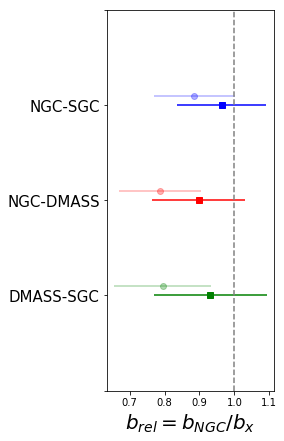

In [232]:
fig, ax = plt.subplots(figsize = (3,7))

brelsqr = np.linspace(0.8, 1.5, 50000) 
b_n = 2.0
brel = np.sqrt(brelsqr)
dbarray = b_n*(1-brel)

ax.errorbar(brel_ns, 3.1, xerr =err_brel_ns, fmt='-o', color='blue', alpha = 0.3)
ax.errorbar(brel_nd, 2.1, xerr =err_brel_nd, fmt='-o', color = 'red', alpha = 0.3)
ax.errorbar(brel_sd, 1.1, xerr =err_brel_sd, fmt='-o', color = 'green', alpha = 0.3)

ax.errorbar(brel_ns*bshift_ns, 3, xerr =err_brel_ns*bshift_ns, fmt='-s', color='blue')
ax.errorbar(brel_nd*bshift_nd, 2, xerr =err_brel_nd*bshift_nd, fmt='-s', color = 'red')
ax.errorbar(brel_sd*bshift_sd, 1, xerr =err_brel_sd*bshift_sd, fmt='-s', color = 'green')

print err_brel_ns*bshift_ns, ',', brel_ns*bshift_ns
print err_brel_nd*bshift_nd, ',', brel_nd*bshift_nd
print err_brel_sd*bshift_sd, ',', brel_sd*bshift_sd

#ax.errorbar(brel_ns_nzs_ratio, 2, xerr = err_brel_ns_nzs_ratio, fmt='-o', color='orange')

#ax.axvline(db_ns, lw = err_brel_ns *b_cmass, alpha = 0.5)
#ax.axvspan(brel_ns-err_brel_ns, brel_ns+err_brel_ns, alpha=0.99, color='skyblue')

#ax.axvspan(brel_sd-err_brel_sd, brel_sd+err_brel_sd, alpha=0.2, color='green')
#ax.axvspan(brel_ns_nzs_ratio-err_brel_ns_nzs_ratio, brel_ns_nzs_ratio+err_db_ns_nzs_ratio, alpha=0.2, color='orange')
#ax.axvspan(brel_nd-err_brel_nd, brel_nd+err_brel_nd, alpha=0.2, color='red')
ax.axvline(x=1.0, color = 'grey', ls='--')
#ax.axvline(x=0, color = 'grey', ls='--')

ax.set_xlabel(r'$b_{rel} = b_{NGC}/b_{x}$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.set_xlim(0.94, 1.1)
#ax.axhline(y = chisqr_min_ns+1)
#ax.axhline(y = chisqr_min_nd+1)
#ax.axhline(y = chisqr_min_sd+1)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['','DMASS-SGC','NGC-DMASS', 'NGC-SGC' ,''], fontsize = 15) 
#print chi2.sf(chisqr_min_ns,9), chi2.sf(chisqr_min_nd,9), chi2.sf(chisqr_min_sd,9)
#print chi2.sf(chinull_ns,9), chi2.sf(chinull_nd,9), chi2.sf(chinull_sd,9)

NameError: name 'db_ns' is not defined

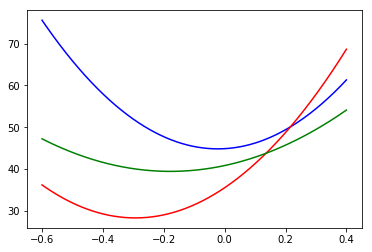

In [22]:
fig, ax = plt.subplots()

b_n = 2.0
brel = np.linspace(0.8, 1.3, 50000)  
dbarray = b_n*(1-brel)

#ax.plot(dbarray, chisqr_result_nn, '-k', label='N-N')
ax.plot(dbarray, chisqr_result_ns, '-b', label='N-S')
ax.plot(dbarray, chisqr_result_nd, '-r',label='N-d')
ax.plot(dbarray, chisqr_result_sd, '-g',label='S-d')
#ax.plot(dbarray, chisqr_result_ns_nzs_ratio, color='orange', ls='--',label='N-S nzs_ratio')

#ax.axvline(x = -0.020420408408168278)
#ax.axvline(x = 0.29054581091621845)
#ax.axvline(x = 0.07538150763015272)
#ax.errorbar(db_ns, chisqr_min_ns, xerr =err_brel_ns *b_cmass)
#ax.errorbar(db_nd, chisqr_min_nd, xerr =err_brel_nd *b_cmass)
#ax.errorbar(db_sd, chisqr_min_sd, xerr =err_brel_sd *b_cmass)

#ax.axvline(db_ns, lw = err_brel_ns *b_cmass, alpha = 0.5)

#ax.axvspan(db_nn-err_db_nn, db_nn+err_db_nn, alpha=0.2, color='grey')
ax.axvspan(db_ns-err_db_ns, db_ns+err_db_ns, alpha=0.99, color='skyblue')
ax.axvspan(db_nd-err_db_nd, db_nd+err_db_nd, alpha=0.2, color='red')
ax.axvspan(db_sd-err_db_sd, db_sd+err_db_sd, alpha=0.2, color='green')
#ax.axvspan(db_ns_nzs_ratio-err_db_ns_nzs_ratio, db_ns_nzs_ratio+err_db_ns_nzs_ratio, alpha=0.2, color='orange')

#ax.axvline(x=0, color = 'grey', ls='--')

ax.set_xlabel(r'$\Delta b$')
ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.axhline(y = chisqr_min_ns+1)
#ax.axhline(y = chisqr_min_nd+1)
#ax.axhline(y = chisqr_min_sd+1)



0.9178178178178178 0.9580280882196606
-0.08762146391414749


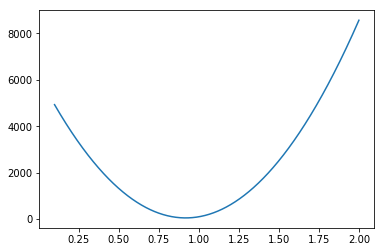

In [253]:
brelsqr = np.linspace(0.1, 2.0, 1000)
chisqr_result = np.zeros(brelsqr.size)

i=0
for b in brelsqr:
    chisqr_result[i] = brelchisqr(xi, xi11, F_cmass, b)
    i+=1

minarg = chisqr_result.argmin()
print brelsqr[minarg], np.sqrt(brelsqr[minarg])
brel = np.sqrt(brelsqr[minarg])
bcmass = 2.0
db = bcmass * (1. - 1./brel)
print db


fig, ax = plt.subplots()
ax.plot(brelsqr, chisqr_result)

In [249]:
1. - 1./np.sqrt(brelsqr[minarg])

-0.0525717487359747

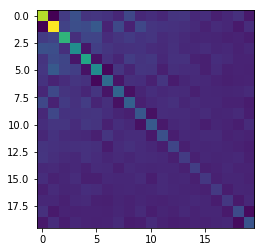

In [197]:
fig, ax = plt.subplots()
ax.imshow(cov_cmass)